In [1]:
import torch
import matplotlib.pyplot as plt
import ESN
import time
import numpy as np
torch.set_default_device("cuda:0")
torch.set_default_dtype(torch.double)
# Parameters
Two,Ttrain = 2000,10000
sigma = 1
N = 50
C = 0.95
dim = 1
actf="identity" 
actf="tanh"


N_d = int(N * dim)
maxtau = int(N * 2)
taus = np.arange(1,maxtau)

#colors = ["r", "g", "b", "c", "m", "y","pink","lime"]
torch.manual_seed(0)
#torch.manual_seed(11)

u_asym = torch.rand(dim, Two + Ttrain)
#u_sym = u_asym
u_sym = 2 * u_asym - 1

esn = ESN.ESN_mult(N_d, uC=C, dim=dim,sigma=sigma)

st = time.time()
Xwo = esn.run_washout(u_sym, Two, actf=actf)
print("runtime :",time.time()-st)


runtime : 0.7125551700592041


In [4]:

st = time.time()
mfs,_,_, mc_sur = ESN.MC_cSVD(u_sym, Xwo,maxtau=maxtau,ret_all=True,sur_sets=10)
print("mc:",time.time()-st)
print("surrogate:",float(mc_sur))
print(torch.sum(mfs))


mc: 0.09197473526000977
surrogate: 0.005056169389151829
tensor(14.4557, device='cuda:0')


In [12]:

maxdd=[[2,10],[3,20],[4,10],[5,20]]

st = time.time()
target_info = ESN.make_targets(u_sym,maxdd,Two=Two)
print(r"target :%d sec"%(time.time()-st))
targets = target_info.tar_f



2 degree:55 target functions
3 degree:1540 target functions
4 degree:715 target functions
5 degree:42504 target functions
target :233 sec


In [6]:
st = time.time()
raw,lin,rev,sur = ESN.calc_capacity(Xwo,targets,ret_all=True)
print("ipc :",time.time()-st)
capacities = rev
dgrs = torch.tensor(target_info.degree)
cap1=capacities

ipc : 0.01983475685119629


In [46]:
st = time.time()
raw,lin,rev,sur = ESN.calc_capacity(Xwo,targets,ret_all=True,forced_sur=mc_sur)
print("ipc :",time.time()-st)
capacities = rev
dgrs = torch.tensor(target_info.degree)
cap2 = capacities

ipc : 0.011625289916992188


In [7]:

d5 = target_info.tar_f[torch.argwhere(dgrs==5)]
d5_mean = torch.mean(d5,2).squeeze()
d5_var = torch.var(d5,2).squeeze()
print(d5_mean,d5_var)
"""
d3 = target_info.tar_f[torch.argwhere(dgrs==3)]
d3_mean = torch.mean(d3)
d3_var = torch.var(d3,2).squeeze()
print(d3_mean,d3_var)

d2 = target_info.tar_f[torch.argwhere(dgrs==2)]
d2_mean = torch.mean(d2)
d2_var = torch.var(d2,2).squeeze()
print(d2_mean,d2_var)


y=d5[50][0].cpu().numpy()
x=np.arange(len(y))
plt.plot(x,y)

"""

tensor([-0.0018,  0.0016, -0.0005,  ...,  0.0022,  0.0023, -0.0017],
       device='cuda:0') tensor([0.0907, 0.0374, 0.0371,  ..., 0.0284, 0.0375, 0.0909], device='cuda:0')


'\nd3 = target_info.tar_f[torch.argwhere(dgrs==3)]\nd3_mean = torch.mean(d3)\nd3_var = torch.var(d3,2).squeeze()\nprint(d3_mean,d3_var)\n\nd2 = target_info.tar_f[torch.argwhere(dgrs==2)]\nd2_mean = torch.mean(d2)\nd2_var = torch.var(d2,2).squeeze()\nprint(d2_mean,d2_var)\n\n\ny=d5[50][0].cpu().numpy()\nx=np.arange(len(y))\nplt.plot(x,y)\n\n'

In [8]:
absmean=torch.abs(torch.mean(target_info.tar_f,1))
var=torch.var(target_info.tar_f,1)

print(absmean.shape)
print(var.shape)
print(capacities.shape)
print(torch.corrcoef(var))
meancap=torch.vstack((absmean,capacities))
varcap=torch.vstack((var,capacities))

print(torch.corrcoef(meancap))
print(torch.corrcoef(varcap))



torch.Size([4312])
torch.Size([4312])
torch.Size([4312])
tensor(1., device='cuda:0')
tensor([[1.0000, 0.0532],
        [0.0532, 1.0000]], device='cuda:0')
tensor([[1.0000, 0.1917],
        [0.1917, 1.0000]], device='cuda:0')


[[1.         0.00866986]
 [0.00866986 1.        ]]
[[1.         0.12466796]
 [0.12466796 1.        ]]


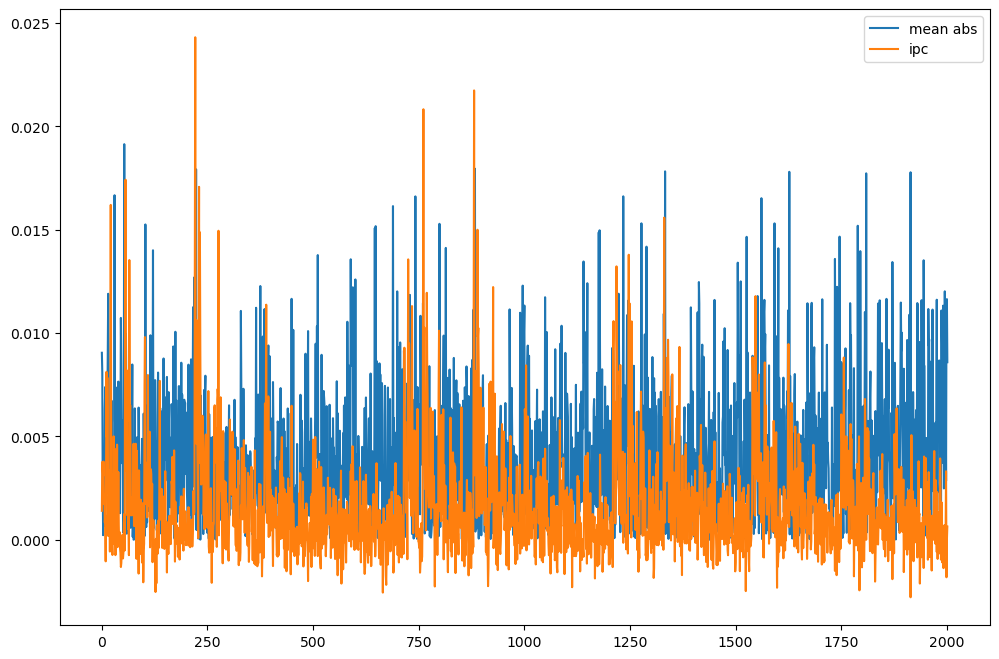

In [9]:
plt.figure(figsize=(12,8))
ax = plt.subplot()
y=d5_mean.cpu().numpy()
y=np.abs(y)
absmean=y
x=np.arange(len(y))
ax.plot(x,y*5,label="mean abs")

y=d5_var.cpu().numpy()
var=y
x=np.arange(len(y))
#ax.plot(x,y,label="var")

y=capacities[torch.argwhere(dgrs==5)].cpu().numpy()
x=np.arange(len(y))
ax.plot(x,y,label="ipc")
plt.legend()

print(np.corrcoef(absmean,y[:,0]))
print(np.corrcoef(var,y[:,0]))

In [10]:
"""
print(float(torch.mean(sur)))
print(torch.mean(raw[torch.argwhere(dgrs==2)]))
print(torch.mean(raw[torch.argwhere(dgrs==3)]))

print(torch.mean(raw[torch.argwhere(dgrs==5)]))
print(torch.mean(rev[torch.argwhere(dgrs==5)]))
print(torch.mean(sur[torch.argwhere(dgrs==5)]))
"""

#print(torch.mean(lin))
print("average ipc value:",float(torch.mean(rev)))

#print(torch.mean(capacities))

totMC=float(torch.sum(mfs))
totCapacity = totMC+float(torch.sum(capacities))
print("totoal capacity:",totCapacity)
print("MC:",totMC)



c_2nd=torch.sum(capacities[torch.argwhere(dgrs==2)])
c_3rd=torch.sum(capacities[torch.argwhere(dgrs==3)])
c_4th=torch.sum(capacities[torch.argwhere(dgrs==4)])
c_5th=torch.sum(capacities[torch.argwhere(dgrs==5)])

print("2nd order ipc:",float(c_2nd))
print("3rd order ipc:",float(c_3rd))
print("4th order ipc:",float(c_4th))
print("5th order ipc:",float(c_5th))

ipc = [totMC,c_2nd,c_3rd,c_4th,c_5th]

average ipc value: 0.0075663523814478864
totoal capacity: 47.0817882027553
MC: 14.45567673395201
2nd order ipc: -0.034965133186860745
3rd order ipc: 29.606010566114932
4th order ipc: -0.15919058991400997
5th order ipc: 3.214256625789228


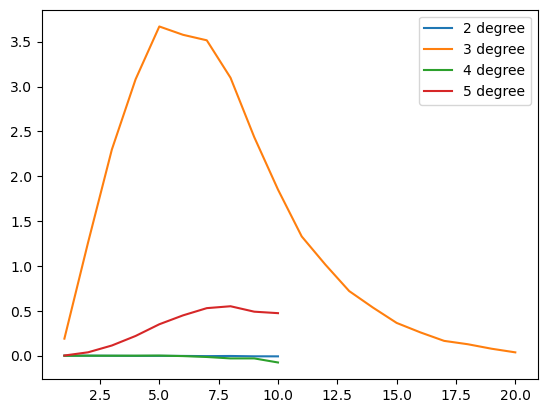

In [11]:
ipc_tau = ESN.ipc_tau(capacities,degrees=target_info.degree,maxdelays=target_info.maxdelay,maxddsets=target_info.maxddset)

for deg in range(len(ipc_tau)):
    plt.plot(np.arange(1,ipc_tau[deg].shape[0]+1),ipc_tau[deg].cpu().numpy(),label=f"{deg+2} degree")

plt.legend()
plt.show()


In [160]:
"""
print(target_info.tar_f[0])
print(u_sym[0][Two:])
#print(capacities[torch.argwhere()])
print(capacities[465:495])
print(capacities[465:495])
print(torch.sum(capacities[465:495]))
"""
print(torch.sum(cap1[10000:]))
print(torch.sum(cap2[10000:]))

#plt.plot(np.arange(capacities.shape[0]),capacities.cpu().numpy())

tensor(3.7548, device='cuda:0')
tensor(2.5502, device='cuda:0')


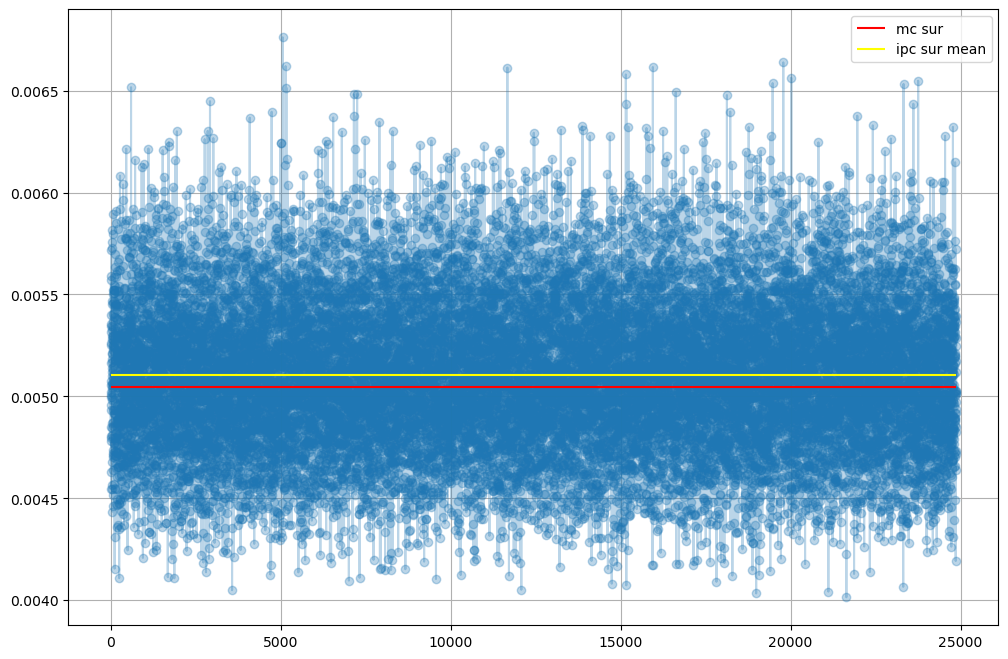

In [165]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(sur.shape[0]),sur.cpu().numpy(),"-o",alpha=0.3)
plt.hlines(y=mc_sur.cpu().numpy(),xmax=0,xmin=sur.shape[0],color="red",label="mc sur")
plt.hlines(y=torch.mean(sur).cpu().numpy(),xmax=0,xmin=sur.shape[0],color="yellow",label="ipc sur mean")
plt.grid(True)
plt.legend()

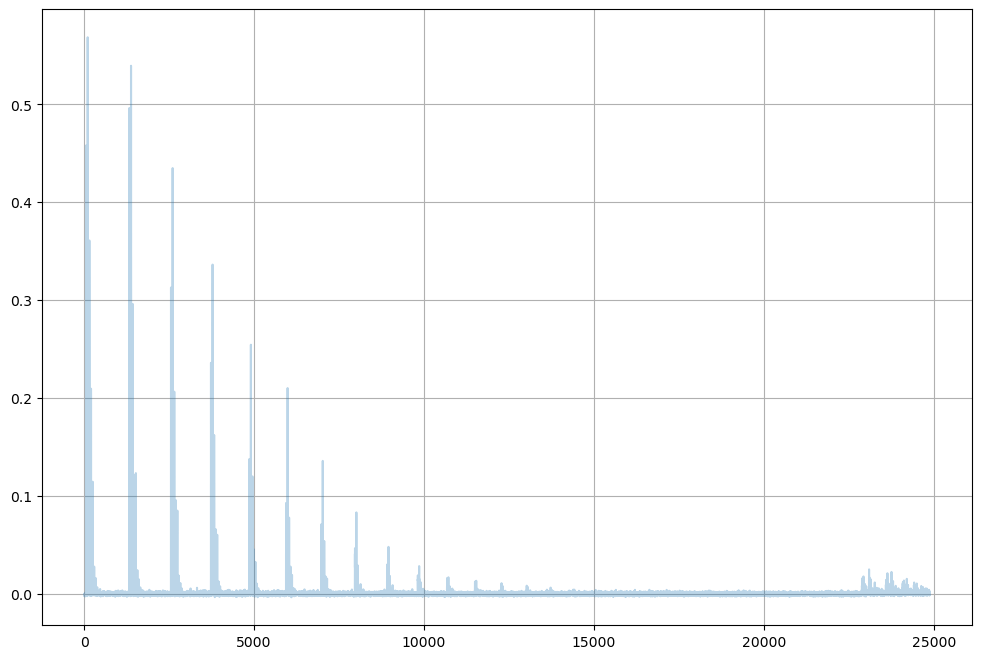

In [162]:
fig,ax = plt.subplots(figsize=(12,8))
y = cap1[:].cpu().numpy()
x = np.arange(len(y))

plt.plot(x,y,"-",alpha=0.3)
plt.grid(True)

2.8066122917853065


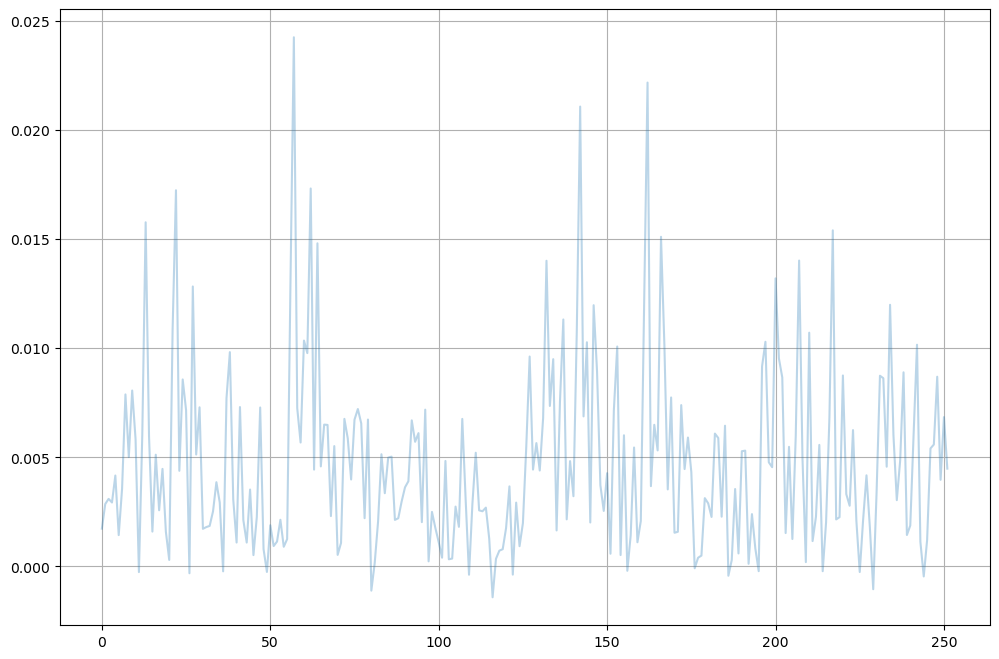

In [104]:
fig,ax = plt.subplots(figsize=(12,8))
d5 = cap1[torch.argwhere(dgrs==5)][:].cpu().numpy()

mxdly = torch.tensor(target_info.maxdelay)
d20 = cap1[torch.argwhere(mxdly==20)][:].cpu().numpy()

d3_20 = cap1[torch.argwhere(dgrs==3)][:].cpu().numpy()

print(np.sum(y))
y = d3_20[10000:]
y = d5[:]

x = np.arange(len(y))

plt.plot(x,y,"-",alpha=0.3)
plt.grid(True)

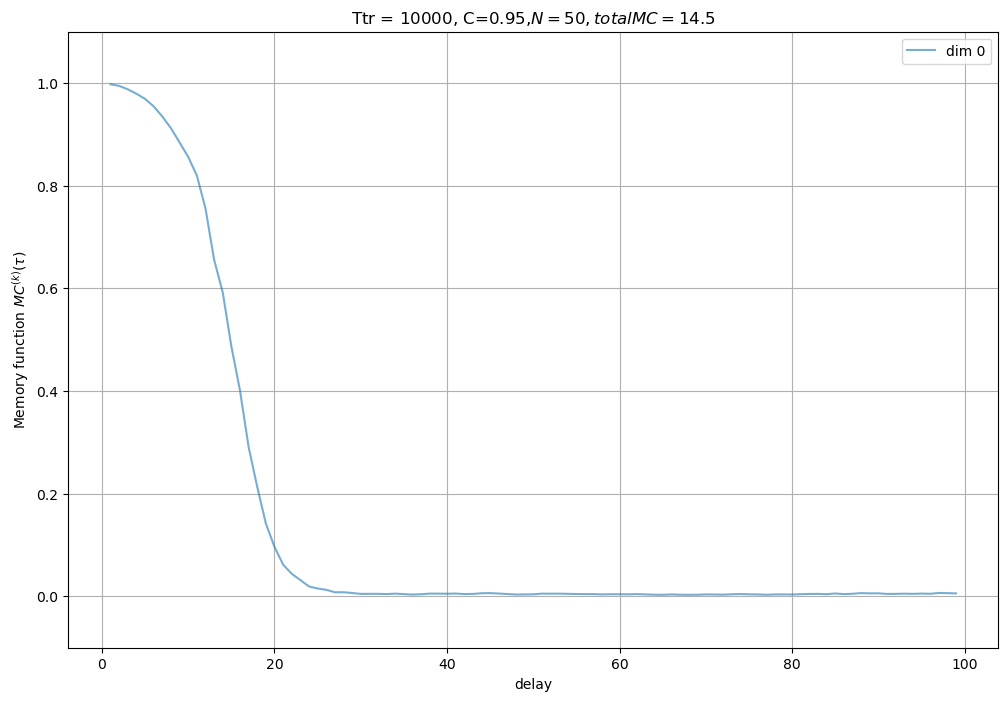

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
for d in range(dim):
    plt.plot(taus,mfs[d].cpu().numpy(),alpha=0.6,label="dim "+str(d))

plt.ylim(-0.1,1.1)
plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totMC))
#
plt.legend()
plt.grid(True)

In [11]:
"""

import csv
from dataclasses import dataclass, asdict

# Save to CSV
with open('test.csv', mode='w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=target_info.__annotations__.keys())
    writer.writeheader()
    writer.writerow(asdict(target_info))


with open('test.csv', mode='r') as csv_file:
    reader = csv.DictReader(csv_file)
    data = next(reader)
    loaded_tarinfo = ESN.Target_Info(**data)

print(len(loaded_tarinfo.degree))
print(loaded_tarinfo.maxddset)

"""

"\n\nimport csv\nfrom dataclasses import dataclass, asdict\n\n# Save to CSV\nwith open('test.csv', mode='w', newline='') as csv_file:\n    writer = csv.DictWriter(csv_file, fieldnames=target_info.__annotations__.keys())\n    writer.writeheader()\n    writer.writerow(asdict(target_info))\n\n\nwith open('test.csv', mode='r') as csv_file:\n    reader = csv.DictReader(csv_file)\n    data = next(reader)\n    loaded_tarinfo = ESN.Target_Info(**data)\n\nprint(len(loaded_tarinfo.degree))\nprint(loaded_tarinfo.maxddset)\n\n"